In [1]:
!pip install deepxde  matplotlib  tensorflow scipy pandas 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 4.2 MB/s eta 0:00:00a 0:00:01


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



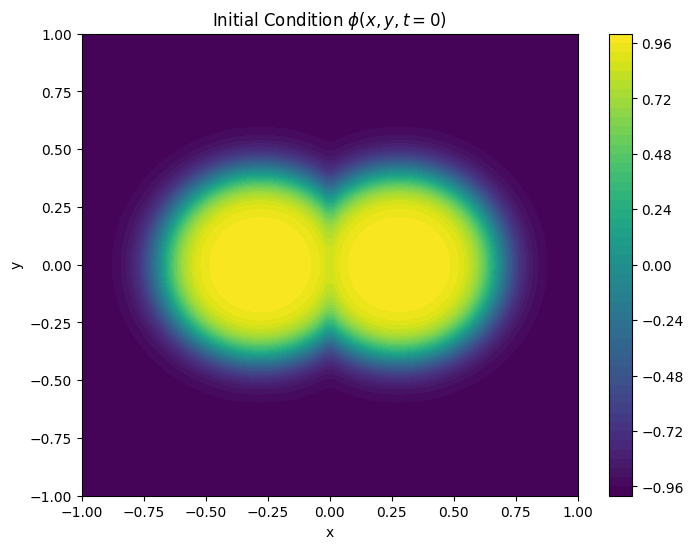

(46228, 3)
Creating model for time: 0.0
Compiling model...
'compile' took 0.169625 s

Training model...



I0000 00:00:1737569587.113190      36 service.cc:145] XLA service 0x590951520660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737569587.113255      36 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1737569588.794799      36 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.25e-01, 4.35e-02, 1.05e-01, 3.23e-01, 9.87e-04, 3.57e-01, 8.48e+02]    [1.25e-01, 4.12e-02, 1.05e-01, 3.23e-01, 9.87e-04, 3.57e-01, 8.48e+02]    []  
1000      [9.92e-03, 1.59e-02, 1.15e-03, 2.43e-03, 1.01e-01, 1.50e-02, 2.77e+00]    [9.89e-03, 1.65e-02, 1.15e-03, 2.43e-03, 1.01e-01, 1.50e-02, 2.77e+00]    []  
2000      [1.37e-03, 9.59e-03, 2.87e-04, 4.41e-04, 1.66e-02, 1.49e-02, 3.25e-01]    [1.38e-03, 1.02e-02, 2.87e-04, 4.41e-04, 1.66e-02, 1.49e-02, 3.25e-01]    []  
3000      [2.31e-04, 8.48e-03, 1.46e-04, 1.35e-04, 2.98e-03, 1.83e-03, 8.79e-02]    [2.30e-04, 9.04e-03, 1.46e-04, 1.35e-04, 2.98e-03, 1.83e-03, 8.79e-02]    []  
4000      [3.96e-05, 8.46e-03, 6.34e-05, 6.49e-05, 1.60e-03, 5.81e-04, 4.38e-02]    [3.97e-05, 9.03e-03, 6.34e-05, 6.49e-05, 1.60e-03, 5.81e-04, 4.38e-02]    []  
5000      [4.31

In [ ]:
import os
# Set backend
os.environ["DDE_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
#import torch
import deepxde as dde
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from deepxde.callbacks import EarlyStopping
np.random.seed(42)

T_start = 0.0
T_step = 0.25
T_end = 0.25 # can set both T_step and T_end to 0.001 for finer granularity 

WIDTH = LENGTH = 1.0

Start_Widht = Start_Length = -1    # Domain Geometry for CA 2D Wight

# Define geometry and time domains
geom = dde.geometry.Rectangle([Start_Widht, Start_Length], [WIDTH, LENGTH])  # Geometry domain

# Constants
epsilon = 0.05
r= 0.4
def cahn_hilliard_Wight(x, y):
    u, mu = y[:, 0:1], y[:, 1:2]
    
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    dmu_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dmu_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    f_h = u**3 - u
    
    eq1 = du_t - (dmu_xx + dmu_yy)
    eq2 = mu - (f_h - epsilon**2 * (du_xx + du_yy))
    
    return [eq1, eq2]

def initial_condition_CA_wight(X):
    x_coord = X[:, 0:1]
    y_coord = X[:, 1:2]
    
    R1 = np.sqrt((x_coord - 0.7 * r) ** 2 + y_coord ** 2)
    R2 = np.sqrt((x_coord + 0.7 * r) ** 2 + y_coord ** 2)
    phi_R1 = np.tanh((r - R1) / (2 * epsilon))
    phi_R2 = np.tanh((r - R2) / (2 * epsilon))
    return np.maximum(phi_R1, phi_R2)

# Generate a meshgrid for visualization
x = np.linspace(Start_Widht, WIDTH, 70)
y = np.linspace(Start_Length, LENGTH, 70)
X, Y = np.meshgrid(x, y)
XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

# Compute the initial condition values
phi_init = initial_condition_CA_wight(XY).reshape(70, 70) # Initial conditon for CA Wight

# Plot the initial condition

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, phi_init, levels=50, cmap='viridis')
plt.colorbar()
plt.title("Initial Condition $\phi(x,y,t=0)$")
plt.xlabel('x')
plt.ylabel('y')
plt.show(block=False)
plt.pause(3)
plt.close()

# visulizing points
def visualize_points(points, high_error_points=None, new_points=None, display_time=3):
    plt.figure(figsize=(10, 6))
    plt.scatter(points[:, 0], points[:, 1], s=5, label='Initial Points', alpha=0.5)
    
    if high_error_points is not None:
        plt.scatter(high_error_points[:, 0], high_error_points[:, 1], s=10, color='red', label='High Error Points')
    
    if new_points is not None:
        plt.scatter(new_points[:, 0], new_points[:, 1], s=10, color='green', label='New Points')
    
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Point Visualization')
    plt.show(block=False)
    plt.pause(display_time)
    plt.close()

# visulizing error distribution
def visualize_error_distribution(errors, threshold, display_time=3):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.show(block=False)
    plt.pause(display_time)
    plt.close()

# adaptive scheme
def adaptive_sampling_eta(model, geomtime, pde, num_samples, error_threshold, neighborhood_size):
    # Generate a large number of random points
    x = geomtime.random_points(num_samples)    
    # Predict the PDE residuals
    f = model.predict(x, operator=pde)
    print("Shape of predicted residuals (f):", [res.shape for res in f])

    # Calculate absolute errors
    err_abs = [np.abs(res) for res in f]  # Calculate absolute error for each residual
    err_abs = np.hstack(err_abs)  # Combine the absolute errors into a single array
    print("Shape of absolute errors (err_abs):", err_abs.shape)

    # We focus on the errors of first ouptut
    eta_errors = err_abs[:, 0]  # Extract the third column for eta1 errors

    # Calculate overall mean error
    err = np.mean(eta_errors)
    print("Mean residual for eta1: %.3e" % err)
    
    # Visualize error distribution
    visualize_error_distribution(eta_errors, err)

    print(f"Number of points exceeding threshold: {np.sum(eta_errors > err)}")

    # Find points where eta1 errors exceed the threshold
    high_error_indices = np.where(eta_errors > err)[0]

    if len(high_error_indices) == 0:
        print("No points found with errors above the threshold.")
        return x[:num_samples]  # Return a subset of the original points
    
    # Select points with high errors
    high_error_points = x[high_error_indices]
    visualize_points(x, high_error_points=high_error_points)  # Visualize high error points
    
    # Limit the number of high error points to ensure we don't generate too many new points
    max_high_error_points = num_samples  # This ensures we don't generate more than num_samples new points
    if len(high_error_points) > max_high_error_points:
        high_error_points = high_error_points[:max_high_error_points]
        
    # Generate new points in the neighborhood of high error points
    new_points = []
    for point in high_error_points:
        for _ in range(2):  # Generate 5 new points for each high error point
            perturbation = np.random.uniform(-neighborhood_size, neighborhood_size, size=point.shape)
            new_point = point + perturbation
            new_point[:2] = np.clip(new_point[:2], geomtime.geometry.bbox[0], geomtime.geometry.bbox[1])
            new_points.append(new_point)

    new_points = np.array(new_points)
    # Ensure the new points are unique
    new_points = np.unique(new_points, axis=0)
    print("Number of new points generated:", len(new_points))

    # Ensure we don't return more than num_samples points
    if len(new_points) > num_samples:
        indices = np.random.choice(len(new_points), num_samples, replace=False)
        new_points = new_points[indices]

    visualize_points(x, high_error_points=high_error_points, new_points=new_points)
    
    return new_points


# Predict at time t
def predict_at_time_2d(model, time, nelx, nely):
    x_lins = np.linspace(Start_Widht, WIDTH, nelx)
    y_lins = np.linspace(Start_Length, LENGTH, nely)
    t_array = np.array([time])
    test_x, test_y, test_t = np.meshgrid(x_lins, y_lins, t_array)
    test_domain = np.vstack((test_x.flatten(), test_y.flatten(), test_t.flatten())).T
    prediction = model.predict(test_domain)
    print(test_x.shape)
    print(test_y.shape)
    print(test_t.shape)
    print(prediction.shape)
    print(test_domain.shape)
    
    
    
    np.savetxt(f"2dCA0.20Prediction{current_time}.txt", np.hstack((test_domain, prediction)), delimiter=' ')
    exit()
    return prediction

# creating IC function for 2D
def create_initial_condition_2d(predictions, x_range, y_range):
    if predictions.size != len(x_range) * len(y_range):
        raise ValueError(f"Cannot reshape array of size {predictions.size} into shape ({len(x_range)}, {len(y_range)})")
    predictions_reshaped = predictions.reshape(len(x_range), len(y_range))
    interp_func = RegularGridInterpolator((x_range, y_range), predictions_reshaped)
    return lambda X: interp_func(X[:, :2]).reshape(-1, 1)


# Neural network
layer_size = [3] + [128] * 5 + [2]
layers = [3, [20] * 4, [20] * 4, [20] * 4, [20] * 4, 4]
ARCHITECTURE = [3] +[ [64,64], [64,64], [64,64], [64,64], [64,64],[64,64]]  + [2]

activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# saving the models
base_save_dir = "./kaggle/working"
os.makedirs(base_save_dir, exist_ok=True)

predictions = []
models = []
# Initialize the domain
nelx = 70
nely = 70
x_linspace = np.linspace(Start_Widht, WIDTH, nelx)
y_linspace = np.linspace(Start_Length, LENGTH, nely)
current_time = T_start

while current_time < T_end:
    next_time = current_time + T_step
    time_domain = dde.geometry.TimeDomain(current_time, next_time)
    geomtime = dde.geometry.GeometryXTime(dde.geometry.Rectangle([Start_Widht, Start_Length], [WIDTH, LENGTH]), time_domain)

    if current_time == 0:
#         ic_function = init_condition_CA_Mattey
          ic_function = initial_condition_CA_wight
    else:
        previous_prediction = predictions[-1][1].reshape(nelx, nely)
        ic_function = create_initial_condition_2d(previous_prediction, x_linspace, y_linspace)
        #compare_ic_with_previous_prediction(current_time, previous_prediction, ic_function, x_linspace, y_linspace)
    
    def on_boundary_x(X, on_boundary):
        x, _, _ = X
        return on_boundary and np.isclose(x, Start_Widht) or np.isclose(x, WIDTH)  # Check if on the left boundary
    def on_boundary_y(X, on_boundary):
        _, y, _ = X
        return on_boundary and np.isclose(y, Start_Length) or np.isclose(y, LENGTH)  # Check if on the left boundary

    # Allen Cahn BC and ICs and Data
    bc_h_x = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=0, component_x=0, on_boundary=on_boundary_x)
    bc_h_y = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=0, component_x=1, on_boundary=on_boundary_y)

    # Periodic Boundary Conditions for the derivative of 'h' in x and y directions
    bc_h_deriv_x = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=1, component_x=0, on_boundary=on_boundary_x)
    bc_h_deriv_y = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=1, component_x=1, on_boundary=on_boundary_y)


    initial_condition_AC_2d = dde.icbc.IC(geomtime, ic_function, lambda _, on_initial: on_initial, component=0)

    data_AC = dde.data.TimePDE(
        geomtime, cahn_hilliard_Wight, [bc_h_x, bc_h_y, bc_h_deriv_x, bc_h_deriv_y, initial_condition_AC_2d],
        num_domain=30000, num_boundary=1600, num_initial=4096, num_test=10000
    )
    
    print(data_AC.train_x.shape)

    if current_time == 0:
        print("Creating model for time:", current_time)
        model = dde.Model(data_AC, net)
    else:
        print("Creating model for time:", current_time)
        previous_model = models[-1]
        previous_weights = previous_model.net.get_weights()
        model = dde.Model(data_AC, net)
        model.net.set_weights(previous_weights)

    # training model
    #model.restore(f"/home/asfandyarkhan/models/CA2D_Wight/time_0.00_to_0.00-130816.ckpt")
    # Create early stopping callback
    early_stopping = EarlyStopping(min_delta=1e-16, patience=10000)
    #model.compile("adam", lr=1e-3, loss='MSE', loss_weights=[10, 10, 1, 1, 1, 1, 100]) # working weights for CA Wight

    # model.compile("adam", lr=1e-3, loss='MSE', loss_weights=[0, 0, 0, 0, 0, 0, 1000])
    # model.train(iterations=100000, batch_size=32)

    model.compile("adam", lr=1e-3, loss='MSE', loss_weights=[1, 1, 1, 1, 1, 1000, 1000])
    model.train(iterations=75000, batch_size=32, callbacks=[early_stopping])

    #Use the function in the training loop
    max_total_points = 70000  # For example
    additional_points = []

    number_of_itrations = 3
    for i in range(number_of_itrations):

        current_total = len(model.data.train_x) #current total points
        print(f"Current total points: {current_total}")
        if current_total >= max_total_points:
            print("Maximum point limit reached. Stopping adaptive sampling.")
            break

        # Adaptive sampling
        x_new = adaptive_sampling_eta(model, geomtime, cahn_hilliard_Wight, num_samples=5000, error_threshold=0.1, neighborhood_size=0.01)

        # Add new points to the training data
        if len(x_new) > 0:
            print(f"Round {number_of_itrations+1}: Adding {len(x_new)} new points")
            model.data.add_anchors(x_new)
        else:
            print(f"Round {number_of_itrations+1}: No new points added")

        # Train the model

        model.compile("adam", lr=1e-3, loss='MSE', loss_weights=[1, 1, 1, 1, 1, 1, 1000])
        model.train(iterations=10000, batch_size=32, callbacks=[early_stopping])

        save_dir = os.path.join(base_save_dir, f"time_{current_time:.2f}_to_{next_time:.2f}")
        os.makedirs(save_dir, exist_ok=True)
        model.save(save_dir)
        print(f"Model saved in {save_dir}")
        
        t_start_prediction = predict_at_time_2d(model, current_time, nelx, nely)[:, 0]
        t_end_prediction = predict_at_time_2d(model, next_time, nelx, nely)[:, 0]
        predictions.append((current_time, t_start_prediction))
        predictions.append((next_time, t_end_prediction))
        
        x = np.linspace(Start_Widht, WIDTH, 100)
        y = np.linspace(Start_Length, LENGTH, 100)
        X, Y = np.meshgrid(x, y)
        
        for time, prediction in predictions:
            plt.figure()
            norm = plt.Normalize(vmin=-1, vmax=1)
            cmap = 'viridis'
            levels = np.linspace(-1, 1, 100)
            plt.contourf(X, Y, prediction.reshape(100, 100), cmap=cmap, levels=50)
            plt.colorbar()
            plt.title(f"Solution for t = {time}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.show()
        
        i += 1
    #         dde.optimizers.config.set_LBFGS_options(maxcor=50, ftol=1e-6, gtol=1e-8, maxiter=10000, maxfun=200000, maxls=50)
    #         model.compile("L-BFGS-B")
    #         losshistory, train_state = model.train()

#Move the saving code here, outside the loop


 